In [1]:
# python version 3.9 활용
import sys
import sidpy
print(sidpy.__version__)

0.12.6


In [2]:
import h5py
import pyNSID
import SciFiReaders as sr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
d_set = sidpy.Dataset.from_array(np.random.random([4,5,10]))
d_set

sidpy.Dataset of type UNKNOWN with:
 dask.array<array, shape=(4, 5, 10), dtype=float64, chunksize=(4, 5, 10), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
a:  generic (generic) of size (4,)
b:  generic (generic) of size (5,)
c:  generic (generic) of size (10,)

In [5]:
# data_type, units, quantity, title, modality, source, _axes, metadata, original_metadata, labels 
d_set.data_type = 'SPECTRAL_IMAGE'
d_set.units = 'A'
d_set.quantity = 'Current'
d_set.modality = 'AFM'

In [6]:
d_set.calibration = np.arange(5)
d_set.metadata = {'experiment':'AFM scan', 'value':[3,3,3,3],'instrument': {'microscope':'Nion','voltage':60000},'humidity':None}

sidpy.dict_utils.print_nested_dict(d_set.metadata)
                  

experiment : AFM scan
value : [3, 3, 3, 3]
instrument :
	microscope : Nion
	voltage : 60000
humidity : None


In [7]:
# 일반적으로 3d의 경우 x,y,voltage 
d_set.set_dimension(0,sidpy.Dimension(np.arange(d_set.shape[0]),
                                      name = 'x',units='um',quantity = 'length',
                                      dimension_type = 'spatial'))

d_set.set_dimension(1,sidpy.Dimension(np.linspace(-2,2,num = d_set.shape[1],endpoint = True),
                                      name = 'y',units='um',quantity = 'length',
                                      dimension_type = 'spatial')) 

d_set.set_dimension(2,sidpy.Dimension(np.sin(np.linspace(0,2*np.pi, num = d_set.shape[2])),
                                      name = 'bias'))

In [8]:
d_set.bias.dimension_type = 'spectral'
d_set.bias.units = 'V'
d_set.bias.quantity ='Bias'

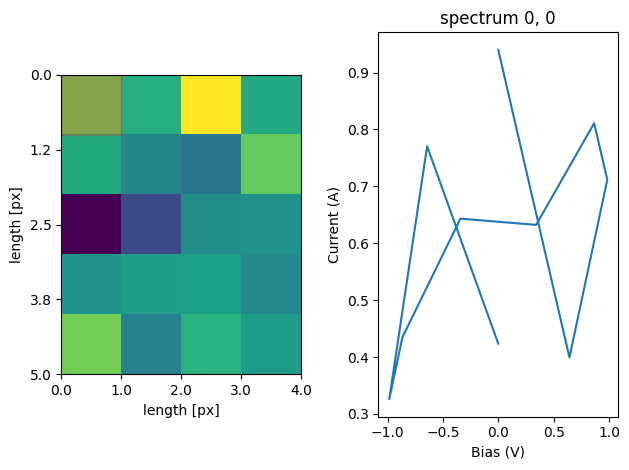

In [ ]:
%matplotlib qt
# local에서 진행하였기에 외부 창 띄워주어야 active visualizer 실행가능
d_set.plot()

In [ ]:
# save
hf = h5py.File('sidpy_params.hf5','a')
hf_group = hf.create_group('experiment_1') 
pyNSID.hdf_io.write_nsid_dataset(d_set,hf_group,main_data_name = 'My_data')
hf.close()

c:\Users\pmsda\anaconda3\envs\pycro\lib\site-packages\pyNSID\io\hdf_utils.py:381: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


In [16]:
hf = h5py.File('./sidpy_params.hf5','r+')
sidpy.hdf_utils.print_tree(hf)

/
├ experiment_1
  ------------
  ├ My_data
    -------
    ├ My_data
    ├ bias
    ├ metadata
      --------
      ├ instrument
        ----------
    ├ provenance
      ----------
      ├ sidpy
        -----
    ├ x
    ├ y


In [15]:
nsid_reader = sr.NSIDReader('./sidpy_params.hf5')
d_set = nsid_reader.read()

In [16]:
print(type(d_set))
print(d_set)

<class 'dict'>
{'Channel_000': sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<array, shape=(4, 5, 10), dtype=float64, chunksize=(4, 5, 10), chunktype=numpy.ndarray>
 data contains: Current (A)
 and Dimensions: 
x:  length (um) of size (4,)
y:  length (um) of size (5,)
bias:  Bias (V) of size (10,)
 with metadata: ['experiment', 'value', 'instrument']}


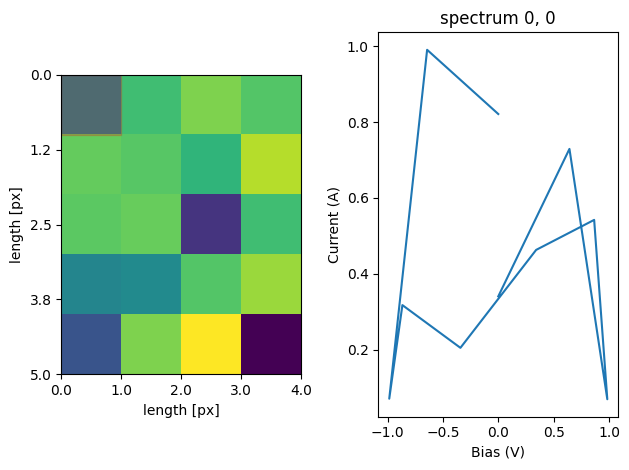

In [17]:
d_set['Channel_000'].plot()

In [18]:
d = d_set['Channel_000']
d.metadata

{'experiment': 'AFM scan',
 'value': array([3, 3, 3, 3]),
 'instrument': {'microscope': 'Nion', 'voltage': 60000}}

In [19]:
# pycroscopy에서 제공하는 sample data 활용
# git clone https://github.com/pycroscopy/pycroscopy.git 후 사용
nsid_reader = sr.NSIDReader('./pycroscopy/sample_data/bfo_iv_final.hf5')
d_set = nsid_reader.read()

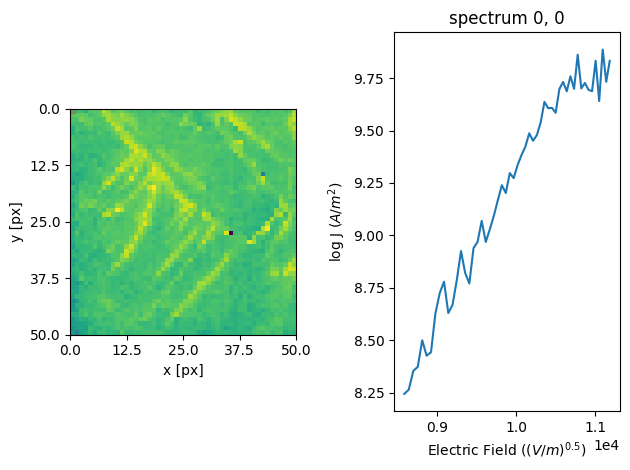

In [20]:
data = d_set['Channel_000']
data.plot()

In [37]:
from sidpy.proc.fitter import SidFitter

def linear_func(xvec,*coeff):
    a1,a2 = coeff
    return a1*xvec + a2

# 위의 linear func를 데이터에 대해 fitting
fitter = SidFitter(data,linear_func,threads=3,return_fit=True,return_std=False,
                   km_guess=True,num_fit_parms=2)

In [38]:
# KM center -> kmeans clustering 사용하여 초기 파라미터 추정 후에 fitting
result = fitter.do_fit()

---Finished KMeans, onto fiting each KM Center---
Fitting center 0
Fitting center 1
Fitting center 2
Fitting center 3
Fitting center 4
Fitting center 5
Fitting center 6
Fitting center 7
Fitting center 8
Fitting center 9
Fitting center 10
Fitting center 11
Fitting center 12
Fitting center 13
Fitting center 14
Fitting center 15
Fitting center 16
Fitting center 17
Fitting center 18
Fitting center 19
Fitting center 20
Fitting center 21
Fitting center 22
Fitting center 23
Fitting center 24


In [ ]:
# result[0] : (50,50,2) , result[1] : (50,50,53)
# a1,a2에 대해 result[0]으로 반환, 원본 데이터 result[1]로 반환환
print(result)

[sidpy.Dataset of type IMAGE_STACK with:
 dask.array<transpose, shape=(50, 50, 2), dtype=float64, chunksize=(50, 50, 2), chunktype=numpy.ndarray>
 data contains: generic (generic)
 and Dimensions: 
x:  x (m) of size (50,)
y:  y (m) of size (50,)
fit_parms:  fit_parameters (a.u.) of size (2,)
 with metadata: ['fit_parms_dict', 'fitting_functions'], sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<transpose, shape=(50, 50, 53), dtype=float64, chunksize=(50, 50, 53), chunktype=numpy.ndarray>
 data contains: log J ($A/m^2$)
 and Dimensions: 
x:  x (m) of size (50,)
y:  y (m) of size (50,)
$\sqrt E$:  Electric Field ($(V/m)^{0.5}$) of size (53,)
 with metadata: ['fit_parms_dict']]


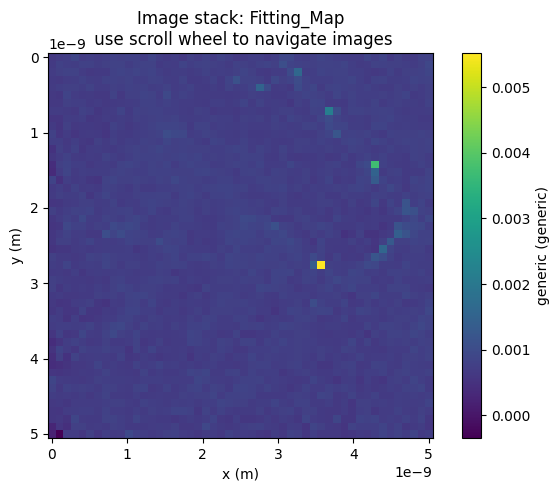

In [ ]:
# a1,a2밖에 없기에 scroll해도 2개밖에 나오지 않음음
result[0].plot()

In [36]:
# 실행해보면 파란점 53개, pixel size 50x50임을 확인할 수 있다.
fitter.visualize_fit_results()

In [41]:
# pycroscopy에서 제공하는 dm3, tiff 파일

dm3_reader = sr.DM3Reader('./pycroscopy/sample_data/bto_atomic.dm3')
img_reader = sr.ImageReader('./pycroscopy/sample_data/re48.tiff')

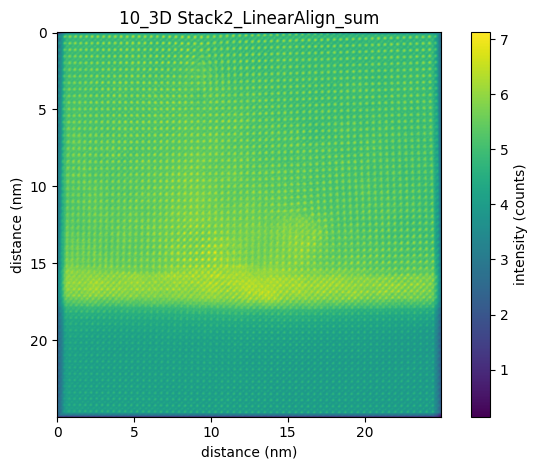

In [42]:
dm3_data = dm3_reader.read()
data = dm3_data['Channel_000']
# 위의 연두색은 barium titanite, 아래 strontium ruthenate, 진한색은 strontium titanate
data.plot()

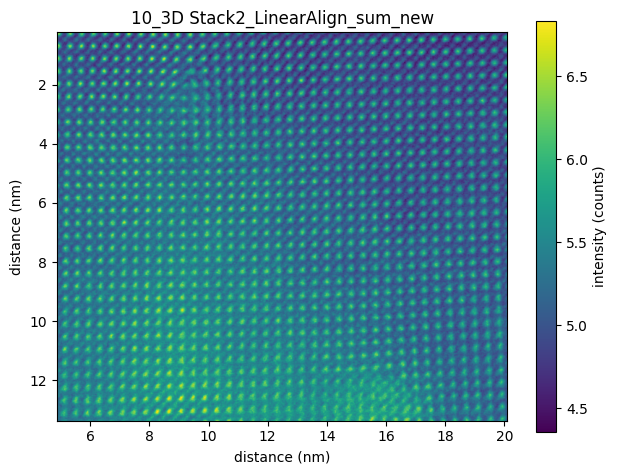

In [ ]:
# data는 (1024,1024) / y:200~824, x:10~548
cropped_data = data[200:-200,10:548]
cropped_data.plot()

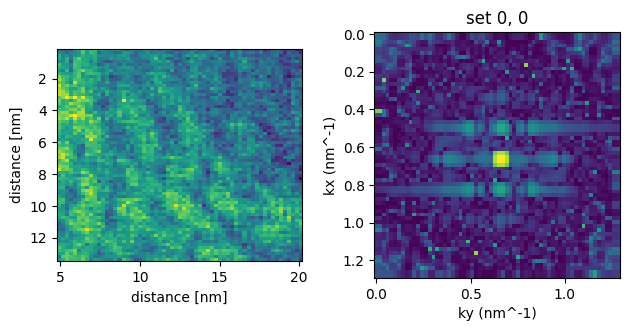

In [ ]:
from pycroscopy.image import ImageWindowing

params_dict = {}
params_dict['window_step_x'] = 8
params_dict['window_step_y'] = 8
params_dict['window_size_x'] = 64   
params_dict['window_size_y'] = 64
# 푸리에 변환, hamming방식 사용
params_dict['mode'] = 'fft'
params_dict['filter'] = 'hamming'
params_dict['zoom_factor'] = 2
params_dict['interpol_factor'] = 2
# windows.shape 하면 8칸씩 이동 계산하면 총 (61, 71, 64, 64) 를 얻을 수 있다. window_size를 64,64
iw = ImageWindowing(params_dict)
windows = iw.MakeWindows(cropped_data)

# 첫번째 abs -> 복소수 크기 계산(실수로 변환), 두번째 abds -> log 변환 후 음수 생길 수 있어 양수로 변환
windows = np.abs(np.log(np.abs(windows)))
windows.plot()

In [50]:
print(windows.shape)
# x는 61
start,end,window_size,step = 10,548,64,8
print(f"x: {len(list(range(start, end - window_size + step, step)))}")
# y는 71
start,end,window_size,step = 200,824,64,8
print(f"y: {len(list(range(start, end - window_size + step, step)))}")

(61, 71, 64, 64)
x: 61
y: 71


In [73]:
from pycroscopy.learn.ml.matrix_factor import MatrixFactor

# 앞서 windows는 모두 양수이므로 Non-negative Matrix Factorization 사용
mfactor = MatrixFactor(windows,method = 'nmf',n_components = 2)
output = mfactor.do_fit()

c:\Users\pmsda\anaconda3\envs\pycro\lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\pmsda\anaconda3\envs\pycro\lib\site-packages\sidpy\base\num_utils.py:54: RuntimeWarning: invalid value encountered in divide
  if var / step_avg < tol:


using generic parameters for dimension  1
using generic parameters for dimension  0


In [74]:
W = np.array(output[0])
H = np.array(output[1])

In [75]:
print(W.shape,H.shape)

(61, 71, 2) (2, 64, 64)


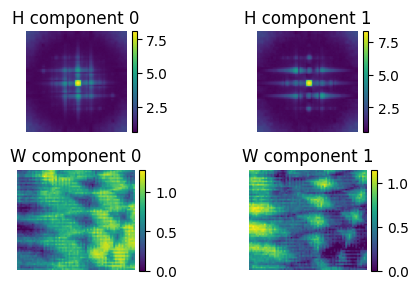

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize = (5,3))
for index in range(2):
    ax = axes[0,index]
    im1 = ax.imshow(H[index,:,:],cmap = 'viridis')
    ax.set_title(f"H component {index}")
    divider = make_axes_locatable(ax) #subplot 주위 새로운 axes추가
    cax = divider.append_axes("right",size = "5%",pad = 0.05)
    fig.colorbar(im1,cax = cax, orientation = 'vertical')
    ax.axis('off')
    
    ax = axes[1,index]
    im2 = ax.imshow(W[:,:,index])
    ax.set_title(f"W component {index}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right",size = "5%",pad = 0.05)
    fig.colorbar(im2, cax = cax, orientation = "vertical")
    ax.axis('off')
fig.tight_layout()
plt.show()